# Empirical Comparison of RNNs and LSTMs on Emotion Classification

This notebook performs an empirical comparison between **RNNs** and **LSTMs** by training models to classify tweets into one of three emotion categories:  
{**sadness**, **neutral**, **happiness**}.

The study is conducted in **three phases**, progressively improving data preprocessing, model complexity, and embedding strategies. Results are visualized and compared to identify the most effective architecture for tweet-based emotion detection.

---

### 📦 Dataset

- **Source**: `tweet_emotions.csv` (provided via module site)
- **Task**: Multi-class classification (3 classes)
- **Input**: Raw tweet text
- **Output**: Emotion label (`sadness`, `neutral`, `happiness`)

---

### ⚙️ Experimental Setup

- **Frameworks**: `TensorFlow 2.12`, `Keras`, `NLTK`, `Matplotlib`, `Seaborn`
- **Embeddings**: Random initialization and `GloVe 6B 100d`
- **Evaluation Metrics**: Accuracy, Precision, Recall, F1-score

---

### 🧠 Model Variants

- **Simple RNN**
- **Simple LSTM**
- **Bidirectional RNN / LSTM**
- Each variant tested:
  - With baseline preprocessing
  - With enhanced preprocessing (emoji demojization, lemmatization)
  - With and without GloVe embeddings

---

### 🔬 Training Configuration

- **Embedding dimension**: 128 (or 100 with GloVe)
- **Sequence length**: 50 tokens
- **Epochs**: 5–15 (with `EarlyStopping`)
- **Batch size**: 32
- **Validation split**: 20%

---

### 📊 Visualizations

- Accuracy comparison per phase
- LSTM vs RNN face-offs
- Final model performance plots (train vs validation)



## Imports

In [146]:
import pandas as pd
import numpy as np
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout


## 🔹 Phase 1: Normal Preprocessing + Baseline Models (RNN & LSTM)
In this phase, we apply basic text normalization and compare the performance of:
- Simple RNN
- Simple LSTM
- RNN + GloVe embeddings
- LSTM + GloVe embeddings

All models are trained on the same input data and evaluated using accuracy and classification metrics.


## Load Dataset & Filter Target Classes


In [147]:
# Load dataset and filter to target emotions
df = pd.read_csv("tweet_emotions.csv/tweet_emotions.csv")
df = df[df['sentiment'].isin(['sadness', 'neutral', 'happiness'])].dropna().copy()

# Preview
df['sentiment'].value_counts()


sentiment
neutral      8638
happiness    5209
sadness      5165
Name: count, dtype: int64

## Basic Preprocessing (Normal Processing)

In [148]:
# Define normal/basic tweet cleaning
def clean_tweet(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"@\w+|#\w+", '', text)
    text = re.sub(r"\d+", '', text)
    text = re.sub(rf"[{re.escape(string.punctuation)}]", '', text)
    text = re.sub(r"\s+", ' ', text).strip()
    return text

# Apply cleaning
df['clean_text'] = df['content'].astype(str).apply(clean_tweet)
df[['content', 'clean_text']].head()


,content,clean_text
1,Layin n bed with a headache ughhhh...waitin o...,layin n bed with a headache ughhhhwaitin on yo...
2,Funeral ceremony...gloomy friday...,funeral ceremonygloomy friday
4,@dannycastillo We want to trade with someone w...,we want to trade with someone who has houston ...
6,"I should be sleep, but im not! thinking about ...",i should be sleep but im not thinking about an...
8,@charviray Charlene my love. I miss you,charlene my love i miss you


## Encode Labels & Tokenize Text

In [149]:
# Encode emotion labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['sentiment'])
y = to_categorical(df['label'], num_classes=3)

# Tokenize clean text
max_words = 10000
max_len = 50

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_text'])
sequences = tokenizer.texts_to_sequences(df['clean_text'])
X = pad_sequences(sequences, maxlen=max_len, padding='post')

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


## Helper function to visualize model performance 

In [150]:
results = []

def log_model_result(name, model, X_test, y_test):
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    results.append({'Model': name, 'Accuracy': acc})
    print(f"[{name}] Accuracy: {acc:.4f}")




histories = {}  # To store training history for each model

## 🔸 Simple RNN (Baseline Model)

This is a basic RNN model using Keras. It consists of:
- An Embedding layer
- A SimpleRNN layer with 128 units
- A dense output layer for 3-class classification


In [151]:
# Define Simple RNN model
model_rnn = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    SimpleRNN(128),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

model_rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
print("Training Simple RNN...")
history_rnn = model_rnn.fit(X_train, y_train, validation_split=0.2, epochs=5, batch_size=32)

histories["Simple RNN (Baseline)"] = history_rnn

log_model_result("Simple RNN (Baseline Model)", model_rnn, X_test, y_test)



Training Simple RNN...
Epoch 1/5


D:\BUB\L6\Deep Learning\deepLearning\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


381/381 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.4361 - loss: 1.0849 - val_accuracy: 0.4520 - val_loss: 1.0865
Epoch 2/5
381/381 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4422 - loss: 1.0791 - val_accuracy: 0.4520 - val_loss: 1.0685
Epoch 3/5
381/381 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4527 - loss: 1.0704 - val_accuracy: 0.4520 - val_loss: 1.0751
Epoch 4/5
381/381 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4537 - loss: 1.0721 - val_accuracy: 0.4520 - val_loss: 1.0687
Epoch 5/5
381/381 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4546 - loss: 1.0687 - val_accuracy: 0.4520 - val_loss: 1.0714
[Simple RNN (Baseline Model)] Accuracy: 0.4544


### Evaluate Simple RNN

In [152]:
# Evaluate RNN
print("Evaluating Simple RNN...")
y_pred_rnn = model_rnn.predict(X_test)
print("Classification Report (RNN):")
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred_rnn, axis=1), target_names=label_encoder.classes_))


Evaluating Simple RNN...
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Classification Report (RNN):
              precision    recall  f1-score   support

   happiness       0.00      0.00      0.00      1042
     neutral       0.45      1.00      0.62      1728
     sadness       0.00      0.00      0.00      1033

    accuracy                           0.45      3803
   macro avg       0.15      0.33      0.21      3803
weighted avg       0.21      0.45      0.28      3803



D:\BUB\L6\Deep Learning\deepLearning\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\BUB\L6\Deep Learning\deepLearning\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\BUB\L6\Deep Learning\deepLearning\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 🔸 Simple LSTM (Baseline Model)

This model uses the same structure as the RNN but replaces the recurrent layer with an LSTM layer.


In [153]:
# Define Simple LSTM model
model_lstm = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    LSTM(128),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
print("Training Simple LSTM...")
history_lstm = model_lstm.fit(X_train, y_train, validation_split=0.2, epochs=5, batch_size=32)


histories["Simple LSTM (Baseline)"] = history_lstm


log_model_result("Simple LSTM (Baseline Model)", model_lstm, X_test, y_test)


Training Simple LSTM...
Epoch 1/5


D:\BUB\L6\Deep Learning\deepLearning\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


381/381 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.4584 - loss: 1.0680 - val_accuracy: 0.4520 - val_loss: 1.0689
Epoch 2/5
381/381 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.4535 - loss: 1.0697 - val_accuracy: 0.4520 - val_loss: 1.0716
Epoch 3/5
381/381 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.4597 - loss: 1.0659 - val_accuracy: 0.4520 - val_loss: 1.0685
Epoch 4/5
381/381 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.4582 - loss: 1.0662 - val_accuracy: 0.4520 - val_loss: 1.0693
Epoch 5/5
381/381 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.4544 - loss: 1.0680 - val_accuracy: 0.4520 - val_loss: 1.0688
[Simple LSTM (Baseline Model)] Accuracy: 0.4544


### Evaluate Simple LSTM

In [154]:
# Evaluate LSTM
print("Evaluating Simple LSTM...")
y_pred_lstm = model_lstm.predict(X_test)
print("Classification Report (LSTM):")
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred_lstm, axis=1), target_names=label_encoder.classes_))


Evaluating Simple LSTM...
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Classification Report (LSTM):
              precision    recall  f1-score   support

   happiness       0.00      0.00      0.00      1042
     neutral       0.45      1.00      0.62      1728
     sadness       0.00      0.00      0.00      1033

    accuracy                           0.45      3803
   macro avg       0.15      0.33      0.21      3803
weighted avg       0.21      0.45      0.28      3803



D:\BUB\L6\Deep Learning\deepLearning\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\BUB\L6\Deep Learning\deepLearning\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\BUB\L6\Deep Learning\deepLearning\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 🔸 Load GloVe Embeddings (100d)

We’ll use `glove.6B.100d.txt`, which must be placed in the working directory.


In [155]:
# Load GloVe 100d vectors
embedding_index = {}
with open("glove.6B.100d.txt", encoding="utf-8") as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

print(f"Loaded {len(embedding_index)} word vectors from GloVe.")


Loaded 400000 word vectors from GloVe.


### Create GloVe Embedding Matrix

In [156]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
word_index = tokenizer.word_index

for word, i in word_index.items():
    if i < max_words:
        vector = embedding_index.get(word)
        if vector is not None:
            embedding_matrix[i] = vector


## 🔸 Simple RNN with GloVe Embeddings

Uses preloaded GloVe vectors with `trainable=False`.


In [157]:
# Define RNN with GloVe
model_rnn_glove = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len,
              weights=[embedding_matrix], trainable=False),
    SimpleRNN(128),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

model_rnn_glove.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
print("Training RNN with GloVe...")
history_rnn_glove = model_rnn_glove.fit(X_train, y_train, validation_split=0.2, epochs=5, batch_size=32)

histories["Simple RNN + GloVe"] = history_rnn_glove


log_model_result("Simple RNN (GloVe)", model_rnn_glove, X_test, y_test)



Training RNN with GloVe...
Epoch 1/5


D:\BUB\L6\Deep Learning\deepLearning\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


381/381 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4293 - loss: 1.0865 - val_accuracy: 0.4520 - val_loss: 1.0700
Epoch 2/5
381/381 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4294 - loss: 1.0822 - val_accuracy: 0.4520 - val_loss: 1.0771
Epoch 3/5
381/381 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4456 - loss: 1.0755 - val_accuracy: 0.4520 - val_loss: 1.0696
Epoch 4/5
381/381 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4514 - loss: 1.0685 - val_accuracy: 0.4520 - val_loss: 1.0692
Epoch 5/5
381/381 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4598 - loss: 1.0668 - val_accuracy: 0.4520 - val_loss: 1.0685
[Simple RNN (GloVe)] Accuracy: 0.4544


### Evaluate RNN with GloVe

In [158]:
print("Evaluating RNN with GloVe...")
y_pred_rnn_glove = model_rnn_glove.predict(X_test)
print("Classification Report (RNN + GloVe):")
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred_rnn_glove, axis=1), target_names=label_encoder.classes_))


Evaluating RNN with GloVe...
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Classification Report (RNN + GloVe):
              precision    recall  f1-score   support

   happiness       0.00      0.00      0.00      1042
     neutral       0.45      1.00      0.62      1728
     sadness       0.00      0.00      0.00      1033

    accuracy                           0.45      3803
   macro avg       0.15      0.33      0.21      3803
weighted avg       0.21      0.45      0.28      3803



D:\BUB\L6\Deep Learning\deepLearning\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\BUB\L6\Deep Learning\deepLearning\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\BUB\L6\Deep Learning\deepLearning\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 🔸 Simple LSTM with GloVe Embeddings

Same structure as before, with GloVe vectors in the Embedding layer.


In [159]:
# Define LSTM with GloVe
model_lstm_glove = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len,
              weights=[embedding_matrix], trainable=False),
    LSTM(128),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

model_lstm_glove.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
print("Training LSTM with GloVe...")
history_lstm_glove = model_lstm_glove.fit(X_train, y_train, validation_split=0.2, epochs=5, batch_size=32)


histories["Simple LSTM + GloVe"] = history_lstm_glove


log_model_result("Simple LSTM (GloVe)", model_lstm_glove, X_test, y_test)



Training LSTM with GloVe...
Epoch 1/5


D:\BUB\L6\Deep Learning\deepLearning\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


381/381 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.4607 - loss: 1.0546 - val_accuracy: 0.4987 - val_loss: 1.0101
Epoch 2/5
381/381 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.5089 - loss: 1.0005 - val_accuracy: 0.5375 - val_loss: 0.9657
Epoch 3/5
381/381 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.5235 - loss: 0.9724 - val_accuracy: 0.5631 - val_loss: 0.9378
Epoch 4/5
381/381 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.5685 - loss: 0.9427 - val_accuracy: 0.6098 - val_loss: 0.8675
Epoch 5/5
381/381 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.6119 - loss: 0.8766 - val_accuracy: 0.6128 - val_loss: 0.8750
[Simple LSTM (GloVe)] Accuracy: 0.5872


### Evaluate LSTM with GloVe

In [160]:
print("Evaluating LSTM with GloVe...")
y_pred_lstm_glove = model_lstm_glove.predict(X_test)
print("Classification Report (LSTM + GloVe):")
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred_lstm_glove, axis=1), target_names=label_encoder.classes_))


Evaluating LSTM with GloVe...
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Classification Report (LSTM + GloVe):
              precision    recall  f1-score   support

   happiness       0.54      0.53      0.54      1042
     neutral       0.62      0.60      0.61      1728
     sadness       0.58      0.61      0.60      1033

    accuracy                           0.59      3803
   macro avg       0.58      0.58      0.58      3803
weighted avg       0.59      0.59      0.59      3803



# 🔹 Phase 2: Enhanced Preprocessing + RNN & LSTM Models
In this phase, we apply advanced tweet cleaning and lemmatization, then re-evaluate:
- Simple RNN
- Simple LSTM
- RNN + GloVe
- LSTM + GloVe


## Import Required Libraries for Cleaning

In [161]:
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download once
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\7ahme\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\7ahme\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Define Enhanced Cleaning Function

In [162]:
def advanced_clean_tweet(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"@\w+", '', text)
    text = re.sub(r"#", '', text)  # keep the word, remove hash
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = emoji.demojize(text)
    text = re.sub(r"\d+", '', text)
    text = re.sub(r"\s+", ' ', text).strip()

    # Lemmatize each token
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    #tokens = text.split()
    #tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    '''
    Using stop words alters the data heavily.
    Example output:
    "@charviray Charlene my love. I miss you" Becomes "charlene love miss"
    '''
    return ' '.join(tokens)
    

## Apply Enhanced Cleaning

In [163]:
# Create new DataFrame for enhanced cleaning
df_adv = df.copy()
df_adv['clean_text'] = df_adv['content'].astype(str).apply(advanced_clean_tweet)
df_adv[['content', 'clean_text']].head()


,content,clean_text
1,Layin n bed with a headache ughhhh...waitin o...,layin n bed with a headache ughhhhwaitin on yo...
2,Funeral ceremony...gloomy friday...,funeral ceremonygloomy friday
4,@dannycastillo We want to trade with someone w...,we want to trade with someone who ha houston t...
6,"I should be sleep, but im not! thinking about ...",i should be sleep but im not thinking about an...
8,@charviray Charlene my love. I miss you,charlene my love i miss you


## Tokenize, Encode Labels, and Prepare Sequences

In [164]:
# Label encoding
label_encoder_adv = LabelEncoder()
df_adv['label'] = label_encoder_adv.fit_transform(df_adv['sentiment'])
y_adv = to_categorical(df_adv['label'], num_classes=3)

# Tokenizer and padding
tokenizer_adv = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer_adv.fit_on_texts(df_adv['clean_text'])

sequences_adv = tokenizer_adv.texts_to_sequences(df_adv['clean_text'])
X_adv = pad_sequences(sequences_adv, maxlen=max_len, padding='post')

# Split
X_train_adv, X_test_adv, y_train_adv, y_test_adv = train_test_split(X_adv, y_adv, stratify=y_adv, test_size=0.2, random_state=42)


## 🔸 Simple RNN with Enhanced Preprocessing

We now train a Simple RNN on the lemmatized and emoji-normalized tweet dataset.


In [165]:
# Simple RNN on enhanced data
model_rnn_adv = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    SimpleRNN(128),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

model_rnn_adv.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("Training Simple RNN (enhanced)...")
history_rnn_adv = model_rnn_adv.fit(X_train_adv, y_train_adv, validation_split=0.2, epochs=5, batch_size=32)


histories["Simple RNN + Enhanced Preprocessing"] = history_rnn_adv


log_model_result("Simple RNN (Enhanced Preprocessing)", model_rnn_adv, X_test_adv, y_test_adv)



Training Simple RNN (enhanced)...
Epoch 1/5


D:\BUB\L6\Deep Learning\deepLearning\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


381/381 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.4308 - loss: 1.0855 - val_accuracy: 0.4520 - val_loss: 1.0788
Epoch 2/5
381/381 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.4417 - loss: 1.0834 - val_accuracy: 0.4560 - val_loss: 1.0683
Epoch 3/5
381/381 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.4546 - loss: 1.0719 - val_accuracy: 0.4517 - val_loss: 1.0691
Epoch 4/5
381/381 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.4580 - loss: 1.0667 - val_accuracy: 0.4520 - val_loss: 1.0685
Epoch 5/5
381/381 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.4519 - loss: 1.0709 - val_accuracy: 0.4520 - val_loss: 1.0739
[Simple RNN (Enhanced Preprocessing)] Accuracy: 0.4544


### Evaluate Simple RNN (Enhanced)

In [166]:
print("Evaluating Simple RNN (enhanced)...")
y_pred_rnn_adv = model_rnn_adv.predict(X_test_adv)
print("Classification Report (Simple RNN - Enhanced):")
print(classification_report(np.argmax(y_test_adv, axis=1), np.argmax(y_pred_rnn_adv, axis=1), target_names=label_encoder_adv.classes_))


Evaluating Simple RNN (enhanced)...
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Classification Report (Simple RNN - Enhanced):
              precision    recall  f1-score   support

   happiness       0.00      0.00      0.00      1042
     neutral       0.45      1.00      0.62      1728
     sadness       0.00      0.00      0.00      1033

    accuracy                           0.45      3803
   macro avg       0.15      0.33      0.21      3803
weighted avg       0.21      0.45      0.28      3803



D:\BUB\L6\Deep Learning\deepLearning\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\BUB\L6\Deep Learning\deepLearning\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\BUB\L6\Deep Learning\deepLearning\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 🔸 Simple LSTM with Enhanced Preprocessing

Next, we train a Simple LSTM model on the same input for comparison.


In [167]:
# Simple LSTM on enhanced data
model_lstm_adv = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    LSTM(128),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

model_lstm_adv.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("Training Simple LSTM (enhanced)...")
history_lstm_adv = model_lstm_adv.fit(X_train_adv, y_train_adv, validation_split=0.2, epochs=5, batch_size=32)

histories["Simple LSTM + Enhanced Preprocessing"] = history_lstm_adv


log_model_result("Simple LSTM (Enhanced Preprocessing)", model_lstm_adv, X_test_adv, y_test_adv)



Training Simple LSTM (enhanced)...
Epoch 1/5


D:\BUB\L6\Deep Learning\deepLearning\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


381/381 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.4534 - loss: 1.0734 - val_accuracy: 0.4520 - val_loss: 1.0701
Epoch 2/5
381/381 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.4628 - loss: 1.0653 - val_accuracy: 0.4520 - val_loss: 1.0710
Epoch 3/5
381/381 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.4551 - loss: 1.0679 - val_accuracy: 0.4520 - val_loss: 1.0684
Epoch 4/5
381/381 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.4556 - loss: 1.0676 - val_accuracy: 0.4520 - val_loss: 1.0692
Epoch 5/5
381/381 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.4539 - loss: 1.0674 - val_accuracy: 0.4520 - val_loss: 1.0691
[Simple LSTM (Enhanced Preprocessing)] Accuracy: 0.4544


### Evaluate Simple LSTM (Enhanced)

In [168]:
print("Evaluating Simple LSTM (enhanced)...")
y_pred_lstm_adv = model_lstm_adv.predict(X_test_adv)
print("Classification Report (Simple LSTM - Enhanced):")
print(classification_report(np.argmax(y_test_adv, axis=1), np.argmax(y_pred_lstm_adv, axis=1), target_names=label_encoder_adv.classes_))


Evaluating Simple LSTM (enhanced)...
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Classification Report (Simple LSTM - Enhanced):
              precision    recall  f1-score   support

   happiness       0.00      0.00      0.00      1042
     neutral       0.45      1.00      0.62      1728
     sadness       0.00      0.00      0.00      1033

    accuracy                           0.45      3803
   macro avg       0.15      0.33      0.21      3803
weighted avg       0.21      0.45      0.28      3803



D:\BUB\L6\Deep Learning\deepLearning\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\BUB\L6\Deep Learning\deepLearning\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\BUB\L6\Deep Learning\deepLearning\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 🔸 Create GloVe Embedding Matrix (Enhanced Tokenizer)

We rebuild the GloVe embedding matrix using the tokenizer fitted on enhanced-cleaned text.


In [169]:
embedding_matrix_adv = np.zeros((max_words, embedding_dim))
word_index_adv = tokenizer_adv.word_index

for word, i in word_index_adv.items():
    if i < max_words:
        vector = embedding_index.get(word)
        if vector is not None:
            embedding_matrix_adv[i] = vector


## RNN + GloVe (Enhanced Preprocessing)

In [170]:
model_rnn_glove_adv = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim,
              input_length=max_len, weights=[embedding_matrix_adv], trainable=False),
    SimpleRNN(128),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

model_rnn_glove_adv.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("Training RNN + GloVe (enhanced)...")
history_rnn_adv_glove = model_rnn_glove_adv.fit(X_train_adv, y_train_adv, validation_split=0.2, epochs=5, batch_size=32)

histories["RNN + Enhanced Preprocessing and GloVe"] = history_rnn_adv_glove


log_model_result("RNN + GloVe (Enhanced Preprocessing)", model_rnn_glove_adv, X_test_adv, y_test_adv)



Training RNN + GloVe (enhanced)...
Epoch 1/5


D:\BUB\L6\Deep Learning\deepLearning\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


381/381 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.4241 - loss: 1.0889 - val_accuracy: 0.4520 - val_loss: 1.0805
Epoch 2/5
381/381 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4326 - loss: 1.0883 - val_accuracy: 0.4520 - val_loss: 1.0806
Epoch 3/5
381/381 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.4306 - loss: 1.0823 - val_accuracy: 0.4467 - val_loss: 1.0791
Epoch 4/5
381/381 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.4369 - loss: 1.0879 - val_accuracy: 0.4520 - val_loss: 1.0661
Epoch 5/5
381/381 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.4600 - loss: 1.0671 - val_accuracy: 0.4520 - val_loss: 1.0716
[RNN + GloVe (Enhanced Preprocessing)] Accuracy: 0.4544


### Evaluate RNN + GloVe (Enhanced)

In [171]:
print("Evaluating RNN + GloVe (enhanced)...")
y_pred_rnn_glove_adv = model_rnn_glove_adv.predict(X_test_adv)
print("Classification Report (RNN + GloVe - Enhanced):")
print(classification_report(np.argmax(y_test_adv, axis=1), np.argmax(y_pred_rnn_glove_adv, axis=1), target_names=label_encoder_adv.classes_))


Evaluating RNN + GloVe (enhanced)...
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Classification Report (RNN + GloVe - Enhanced):
              precision    recall  f1-score   support

   happiness       0.00      0.00      0.00      1042
     neutral       0.45      1.00      0.62      1728
     sadness       0.00      0.00      0.00      1033

    accuracy                           0.45      3803
   macro avg       0.15      0.33      0.21      3803
weighted avg       0.21      0.45      0.28      3803



D:\BUB\L6\Deep Learning\deepLearning\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\BUB\L6\Deep Learning\deepLearning\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\BUB\L6\Deep Learning\deepLearning\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 🔸 Simple LSTM with GloVe (Enhanced Preprocessing)

Same as above, but using an LSTM layer.


In [172]:
model_lstm_glove_adv = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim,
              input_length=max_len, weights=[embedding_matrix_adv], trainable=False),
    LSTM(128),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

model_lstm_glove_adv.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("Training LSTM + GloVe (enhanced)...")
history_lstm_adv_glove = model_lstm_glove_adv.fit(X_train_adv, y_train_adv, validation_split=0.2, epochs=5, batch_size=32)


histories["LSTM + Enhanced Preprocessing and GloVe"] = history_lstm_adv_glove


log_model_result("LSTM + GloVe (Enhanced Preprocessing)", model_lstm_glove_adv, X_test_adv, y_test_adv)



Training LSTM + GloVe (enhanced)...
Epoch 1/5


D:\BUB\L6\Deep Learning\deepLearning\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


381/381 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.4610 - loss: 1.0496 - val_accuracy: 0.4875 - val_loss: 1.0078
Epoch 2/5
381/381 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.4789 - loss: 1.0121 - val_accuracy: 0.3955 - val_loss: 1.0627
Epoch 3/5
381/381 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.4974 - loss: 0.9965 - val_accuracy: 0.5131 - val_loss: 0.9817
Epoch 4/5
381/381 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.5252 - loss: 0.9763 - val_accuracy: 0.5753 - val_loss: 0.9567
Epoch 5/5
381/381 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.5779 - loss: 0.9419 - val_accuracy: 0.6039 - val_loss: 0.8900
[LSTM + GloVe (Enhanced Preprocessing)] Accuracy: 0.5903


### Evaluate LSTM + GloVe (Enhanced)

In [173]:
print("Evaluating LSTM + GloVe (enhanced)...")
y_pred_lstm_glove_adv = model_lstm_glove_adv.predict(X_test_adv)
print("Classification Report (LSTM + GloVe - Enhanced):")
print(classification_report(np.argmax(y_test_adv, axis=1), np.argmax(y_pred_lstm_glove_adv, axis=1), target_names=label_encoder_adv.classes_))


Evaluating LSTM + GloVe (enhanced)...
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Classification Report (LSTM + GloVe - Enhanced):
              precision    recall  f1-score   support

   happiness       0.54      0.60      0.57      1042
     neutral       0.64      0.59      0.61      1728
     sadness       0.57      0.58      0.57      1033

    accuracy                           0.59      3803
   macro avg       0.58      0.59      0.59      3803
weighted avg       0.59      0.59      0.59      3803



# 🔹 Phase 3: Bidirectional RNN & LSTM (with and without GloVe)

In this final phase, we test:
- Bidirectional SimpleRNN
- Bidirectional LSTM
- Both with and without GloVe
All use enhanced preprocessing + EarlyStopping.


## Import EarlyStopping

In [174]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


## 🔸 Bidirectional Simple RNN (Enhanced Preprocessing)

This model uses a Bidirectional wrapper around SimpleRNN to allow context flow in both directions.


In [175]:
# Bidirectional RNN (No GloVe)
from tensorflow.keras.layers import Bidirectional, SimpleRNN

model_birnn = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    Bidirectional(SimpleRNN(128)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

model_birnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("Training Bidirectional RNN (enhanced)...")
history_birnn = model_birnn.fit(X_train_adv, y_train_adv, validation_split=0.2, epochs=20, batch_size=32, callbacks=[early_stop])


histories["Bi-RNN + Enhanced Preprocessing"] = history_birnn


log_model_result("Bi-RNN (Enhanced Preprocessing)", model_birnn, X_test_adv, y_test_adv)



Training Bidirectional RNN (enhanced)...
Epoch 1/20


D:\BUB\L6\Deep Learning\deepLearning\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


381/381 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.4231 - loss: 1.0838 - val_accuracy: 0.5138 - val_loss: 0.9914
Epoch 2/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.5546 - loss: 0.9527 - val_accuracy: 0.5884 - val_loss: 0.8864
Epoch 3/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.7007 - loss: 0.7084 - val_accuracy: 0.5717 - val_loss: 0.9723
Epoch 4/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.8353 - loss: 0.4258 - val_accuracy: 0.5556 - val_loss: 1.1372
Epoch 5/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.9191 - loss: 0.2238 - val_accuracy: 0.5424 - val_loss: 1.4829
[Bi-RNN (Enhanced Preprocessing)] Accuracy: 0.5759


### Evaluate Bidirectional RNN

In [176]:
print("Evaluating Bidirectional RNN (enhanced)...")
y_pred_birnn = model_birnn.predict(X_test_adv)
print("Classification Report (Bidirectional RNN - Enhanced):")
print(classification_report(np.argmax(y_test_adv, axis=1), np.argmax(y_pred_birnn, axis=1), target_names=label_encoder_adv.classes_))


Evaluating Bidirectional RNN (enhanced)...
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Classification Report (Bidirectional RNN - Enhanced):
              precision    recall  f1-score   support

   happiness       0.56      0.45      0.50      1042
     neutral       0.56      0.76      0.64      1728
     sadness       0.67      0.39      0.49      1033

    accuracy                           0.58      3803
   macro avg       0.60      0.53      0.55      3803
weighted avg       0.59      0.58      0.56      3803



## 🔸 Bidirectional LSTM (Enhanced Preprocessing)

This model uses a Bidirectional wrapper around LSTM to allow context flow in both directions.


In [177]:
#Bidirectional LSTM (No GloVe)
model_bilstm = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(128)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

model_bilstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("Training Bidirectional LSTM (enhanced)...")
history_bilstm = model_bilstm.fit(X_train_adv, y_train_adv, validation_split=0.2, epochs=20, batch_size=32, callbacks=[early_stop])


histories["Bi-LSTM + Enhanced Preprocessing"] = history_bilstm


log_model_result("Bi-LSTM (Enhanced Preprocessing)", model_bilstm, X_test_adv, y_test_adv)



Training Bidirectional LSTM (enhanced)...
Epoch 1/20


D:\BUB\L6\Deep Learning\deepLearning\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


381/381 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.5016 - loss: 1.0137 - val_accuracy: 0.6216 - val_loss: 0.8494
Epoch 2/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.6872 - loss: 0.7277 - val_accuracy: 0.6164 - val_loss: 0.8505
Epoch 3/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.7584 - loss: 0.5957 - val_accuracy: 0.6022 - val_loss: 0.9321
Epoch 4/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.8074 - loss: 0.4740 - val_accuracy: 0.5957 - val_loss: 1.0401
[Bi-LSTM (Enhanced Preprocessing)] Accuracy: 0.6079


### Evaluate Bidirectional LSTM

In [178]:
print("Evaluating Bidirectional LSTM (enhanced)...")
y_pred_bilstm = model_bilstm.predict(X_test_adv)
print("Classification Report (Bidirectional LSTM - Enhanced):")
print(classification_report(np.argmax(y_test_adv, axis=1), np.argmax(y_pred_bilstm, axis=1), target_names=label_encoder_adv.classes_))


Evaluating Bidirectional LSTM (enhanced)...
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
Classification Report (Bidirectional LSTM - Enhanced):
              precision    recall  f1-score   support

   happiness       0.64      0.44      0.52      1042
     neutral       0.61      0.70      0.65      1728
     sadness       0.58      0.63      0.60      1033

    accuracy                           0.61      3803
   macro avg       0.61      0.59      0.59      3803
weighted avg       0.61      0.61      0.60      3803



# 🔸 Bidirectional RNN + GloVe (Enhanced Preprocessing)

This model uses GloVe embeddings and a bidirectional SimpleRNN for improved context learning.


In [179]:
model_birnn_glove = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len,
              weights=[embedding_matrix_adv], trainable=False),
    Bidirectional(SimpleRNN(128)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

model_birnn_glove.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("Training Bidirectional RNN + GloVe (enhanced)...")
history_birnn_glove = model_birnn_glove.fit(X_train_adv, y_train_adv, validation_split=0.2, epochs=15, batch_size=32, callbacks=[early_stop])


histories["Bi-RNN + Enhanced Preprocessing and GloVe"] = history_birnn_glove


log_model_result("Bi-RNN + GloVe (Enhanced Preprocessing)", model_birnn_glove, X_test_adv, y_test_adv)



Training Bidirectional RNN + GloVe (enhanced)...
Epoch 1/15


D:\BUB\L6\Deep Learning\deepLearning\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


381/381 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.4304 - loss: 1.0854 - val_accuracy: 0.4678 - val_loss: 1.0195
Epoch 2/15
381/381 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5104 - loss: 0.9874 - val_accuracy: 0.5598 - val_loss: 0.9528
Epoch 3/15
381/381 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5405 - loss: 0.9567 - val_accuracy: 0.5674 - val_loss: 0.9197
[Bi-RNN + GloVe (Enhanced Preprocessing)] Accuracy: 0.4688


## Evaluate Bidirectional RNN + GloVe

In [180]:
print("Evaluating Bidirectional RNN + GloVe (enhanced)...")
y_pred_birnn_glove = model_birnn_glove.predict(X_test_adv)
print("Classification Report (Bidirectional RNN + GloVe):")
print(classification_report(np.argmax(y_test_adv, axis=1), np.argmax(y_pred_birnn_glove, axis=1), target_names=label_encoder_adv.classes_))


Evaluating Bidirectional RNN + GloVe (enhanced)...
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Classification Report (Bidirectional RNN + GloVe):
              precision    recall  f1-score   support

   happiness       0.56      0.04      0.07      1042
     neutral       0.47      0.95      0.62      1728
     sadness       0.48      0.11      0.17      1033

    accuracy                           0.47      3803
   macro avg       0.50      0.36      0.29      3803
weighted avg       0.49      0.47      0.35      3803



# 🔸 Bidirectional LSTM + GloVe (Enhanced Preprocessing)

This is our final model combining all enhancements: bidirectionality, GloVe embeddings, and advanced cleaning.


In [181]:
model_bilstm_glove = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len,
              weights=[embedding_matrix_adv], trainable=False),
    Bidirectional(LSTM(128)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

model_bilstm_glove.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("Training Bidirectional LSTM + GloVe (enhanced)...")
history_bilstm_glove = model_bilstm_glove.fit(X_train_adv, y_train_adv, validation_split=0.2, epochs=15, batch_size=32, callbacks=[early_stop])

histories["Bi-LSTM + Enhanced Preprocessing and GloVe"] = history_bilstm_glove


log_model_result("Bi-LSTM + GloVe (Enhanced Preprocessing)", model_bilstm_glove, X_test_adv, y_test_adv)



Training Bidirectional LSTM + GloVe (enhanced)...
Epoch 1/15


D:\BUB\L6\Deep Learning\deepLearning\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


381/381 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.4912 - loss: 1.0169 - val_accuracy: 0.5851 - val_loss: 0.8860
Epoch 2/15
381/381 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5947 - loss: 0.8851 - val_accuracy: 0.6009 - val_loss: 0.8635
Epoch 3/15
381/381 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.6162 - loss: 0.8446 - val_accuracy: 0.6160 - val_loss: 0.8512
[Bi-LSTM + GloVe (Enhanced Preprocessing)] Accuracy: 0.5788


##  Evaluate Bidirectional LSTM + GloVe

In [182]:
print("Evaluating Bidirectional LSTM + GloVe (enhanced)...")
y_pred_bilstm_glove = model_bilstm_glove.predict(X_test_adv)
print("Classification Report (Bidirectional LSTM + GloVe):")
print(classification_report(np.argmax(y_test_adv, axis=1), np.argmax(y_pred_bilstm_glove, axis=1), target_names=label_encoder_adv.classes_))


Evaluating Bidirectional LSTM + GloVe (enhanced)...
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Classification Report (Bidirectional LSTM + GloVe):
              precision    recall  f1-score   support

   happiness       0.60      0.43      0.51      1042
     neutral       0.61      0.65      0.63      1728
     sadness       0.52      0.61      0.56      1033

    accuracy                           0.58      3803
   macro avg       0.58      0.56      0.56      3803
weighted avg       0.58      0.58      0.58      3803



# 🔸 Final Evaluation: Simple vs Bidirectional LSTM (GloVe + Enhanced Preprocessing/ Simple Preprocessing)

We now compare the top 3 models under identical conditions to finalize which is best overall. However, one simple model will use the simple preprocessed data. 


## Rebuild Simple LSTM + GloVe

In [183]:
model_lstm_final = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim,
              input_length=max_len, weights=[embedding_matrix_adv], trainable=False),
    LSTM(128),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

model_lstm_final.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_lstm_final.summary()

print("Retraining Simple LSTM + GloVe (Enhanced)...")

history_lstm_final = model_lstm_final.fit(X_train_adv, y_train_adv, validation_split=0.2, epochs=20, batch_size=32, callbacks=[early_stop])

histories["Simple LSTM + Enhanced Preprocessing and GloVe - Final"] = history_lstm_final


log_model_result("Simple LSTM + GloVe (Enhanced Preprocessing) - Final", model_lstm_final, X_test_adv, y_test_adv)



D:\BUB\L6\Deep Learning\deepLearning\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_49 (Embedding)             │ ?                           │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_32 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_49 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_98 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_99 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)

Retraining Simple LSTM + GloVe (Enhanced)...
Epoch 1/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.4451 - loss: 1.0656 - val_accuracy: 0.4520 - val_loss: 1.0711
Epoch 2/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.4589 - loss: 1.0535 - val_accuracy: 0.4928 - val_loss: 1.0246
Epoch 3/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.5115 - loss: 1.0001 - val_accuracy: 0.5105 - val_loss: 1.0031
[Simple LSTM + GloVe (Enhanced Preprocessing) - Final] Accuracy: 0.4544


### Evaluate Simple LSTM (Final Trial)

In [184]:
y_pred_lstm_final = model_lstm_final.predict(X_test_adv)
print("Final Evaluation - Simple LSTM + GloVe:")
print(classification_report(np.argmax(y_test_adv, axis=1), np.argmax(y_pred_lstm_final, axis=1), target_names=label_encoder_adv.classes_))


119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Final Evaluation - Simple LSTM + GloVe:
              precision    recall  f1-score   support

   happiness       0.00      0.00      0.00      1042
     neutral       0.45      1.00      0.62      1728
     sadness       0.00      0.00      0.00      1033

    accuracy                           0.45      3803
   macro avg       0.15      0.33      0.21      3803
weighted avg       0.21      0.45      0.28      3803



D:\BUB\L6\Deep Learning\deepLearning\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\BUB\L6\Deep Learning\deepLearning\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\BUB\L6\Deep Learning\deepLearning\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Rebuild Bidirectional LSTM + GloVe

In [185]:
from tensorflow.keras.layers import Bidirectional

model_bilstm_final = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim,
              input_length=max_len, weights=[embedding_matrix_adv], trainable=False),
    Bidirectional(LSTM(128)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

model_bilstm_final.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_bilstm_final.summary()

print("Retraining Bidirectional LSTM + GloVe (Enhanced)...")
history_bilstm_final = model_bilstm_final.fit(X_train_adv, y_train_adv, validation_split=0.2, epochs=20, batch_size=32, callbacks=[early_stop])

histories["Bi-LSTM + Enhanced Preprocessing and GloVe - Final"] = history_bilstm_final


log_model_result("Bi-LSTM + GloVe (Enhanced Preprocessing) - Final", model_bilstm_final, X_test_adv, y_test_adv)



D:\BUB\L6\Deep Learning\deepLearning\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_50 (Embedding)             │ ?                           │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_15 (Bidirectional)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_50 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_100 (Dense)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_101 (Dense)                    │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)

Retraining Bidirectional LSTM + GloVe (Enhanced)...
Epoch 1/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.4893 - loss: 1.0142 - val_accuracy: 0.5878 - val_loss: 0.8835
Epoch 2/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5969 - loss: 0.8743 - val_accuracy: 0.6095 - val_loss: 0.8532
Epoch 3/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.6180 - loss: 0.8396 - val_accuracy: 0.6223 - val_loss: 0.8549
[Bi-LSTM + GloVe (Enhanced Preprocessing) - Final] Accuracy: 0.5806


### Evaluate Bidirectional LSTM (Final Trial)

In [186]:
y_pred_bilstm_final = model_bilstm_final.predict(X_test_adv)
print("Final Evaluation - Bidirectional LSTM + GloVe:")
print(classification_report(np.argmax(y_test_adv, axis=1), np.argmax(y_pred_bilstm_final, axis=1), target_names=label_encoder_adv.classes_))


119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Final Evaluation - Bidirectional LSTM + GloVe:
              precision    recall  f1-score   support

   happiness       0.58      0.46      0.52      1042
     neutral       0.57      0.75      0.65      1728
     sadness       0.61      0.41      0.49      1033

    accuracy                           0.58      3803
   macro avg       0.59      0.54      0.55      3803
weighted avg       0.58      0.58      0.57      3803



## Rebuild Simple LSTM + GloVe (with Simple Preprocessing)

In [187]:
# Rebuild LSTM with GloVe (same setup)
model_lstm_glove_final = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len,
              weights=[embedding_matrix], trainable=False),
    LSTM(128),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

model_lstm_glove_final.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_lstm_glove_final.summary()


# Train
print("Training LSTM with GloVe (simple preprocessing, extended)...")
history_lstm_glove_final = model_lstm_glove_final.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=[early_stop]
)

histories["Simple LSTM + Simple Preprocessing and GloVe - Final"] = history_lstm_glove_final


# Log result
log_model_result("Simple LSTM (GloVe) - Final Extended", model_lstm_glove_final, X_test, y_test)


D:\BUB\L6\Deep Learning\deepLearning\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_51 (Embedding)             │ ?                           │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_34 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_51 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_102 (Dense)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_103 (Dense)                    │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)

Training LSTM with GloVe (simple preprocessing, extended)...
Epoch 1/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.4510 - loss: 1.0581 - val_accuracy: 0.4918 - val_loss: 1.0074
Epoch 2/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.4868 - loss: 1.0116 - val_accuracy: 0.5062 - val_loss: 0.9978
Epoch 3/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.5373 - loss: 0.9771 - val_accuracy: 0.5526 - val_loss: 0.9402
[Simple LSTM (GloVe) - Final Extended] Accuracy: 0.4770


In [188]:
# Predict and evaluate
y_pred_lstm_glove_final = model_lstm_glove_final.predict(X_test)
print("Final Evaluation - Simple LSTM + GloVe (Simple Preprocessing, Extended Training):\n")
print(classification_report(
    np.argmax(y_test, axis=1),
    np.argmax(y_pred_lstm_glove_final, axis=1),
    target_names=label_encoder.classes_
))


119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Final Evaluation - Simple LSTM + GloVe (Simple Preprocessing, Extended Training):

              precision    recall  f1-score   support

   happiness       0.34      0.36      0.35      1042
     neutral       0.53      0.83      0.65      1728
     sadness       0.28      0.00      0.01      1033

    accuracy                           0.48      3803
   macro avg       0.38      0.40      0.34      3803
weighted avg       0.41      0.48      0.39      3803



#  🔷 Visualization Phase: Compare RNN vs LSTM

Comparing each model of RNN against its LSTM counterpart

In [189]:
# First we're checking the names of our models

results[:3]
for r in results:
    print(r['Model'])


Simple RNN (Baseline Model)
Simple LSTM (Baseline Model)
Simple RNN (GloVe)
Simple LSTM (GloVe)
Simple RNN (Enhanced Preprocessing)
Simple LSTM (Enhanced Preprocessing)
RNN + GloVe (Enhanced Preprocessing)
LSTM + GloVe (Enhanced Preprocessing)
Bi-RNN (Enhanced Preprocessing)
Bi-LSTM (Enhanced Preprocessing)
Bi-RNN + GloVe (Enhanced Preprocessing)
Bi-LSTM + GloVe (Enhanced Preprocessing)
Simple LSTM + GloVe (Enhanced Preprocessing) - Final
Bi-LSTM + GloVe (Enhanced Preprocessing) - Final
Simple LSTM (GloVe) - Final Extended


In [190]:
# Critical Step to import matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns

## Compare RNN vs LSTM (Baseline Models) and GloVe Models

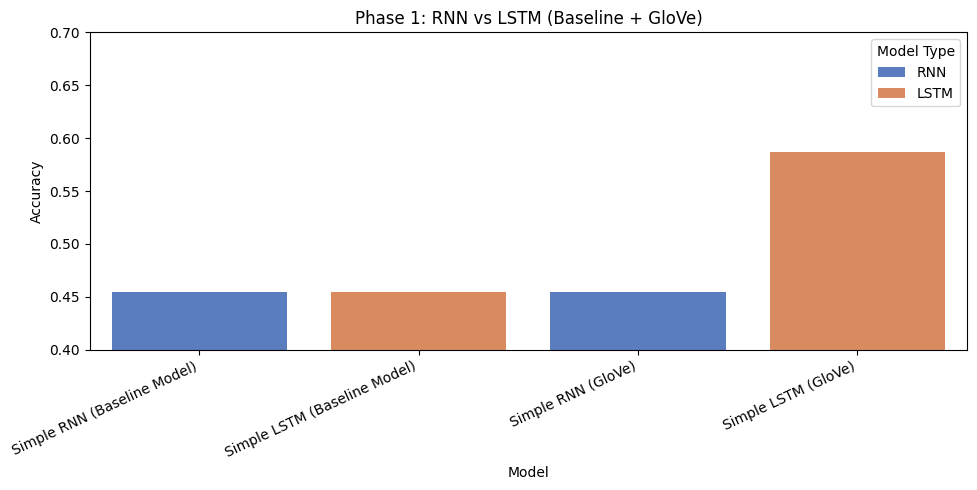

In [213]:
# Filter models
phase1_models = [
    'Simple RNN (Baseline Model)',
    'Simple LSTM (Baseline Model)',
    'Simple RNN (GloVe)',
    'Simple LSTM (GloVe)'
]

df_phase1_all = pd.DataFrame([r for r in results if r['Model'] in phase1_models])

# Add type column
df_phase1_all['Type'] = df_phase1_all['Model'].apply(lambda x: 'RNN' if 'RNN' in x else 'LSTM')

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=df_phase1_all, x='Model', y='Accuracy', hue='Type', palette='muted')
plt.title('Phase 1: RNN vs LSTM (Baseline + GloVe)')
plt.ylim(0.4, 0.7)
plt.ylabel('Accuracy')
plt.xticks(rotation=25, ha='right')
plt.legend(title='Model Type')
plt.tight_layout()


plt.savefig("phase1.png", dpi=300, bbox_inches='tight')


plt.show()




## Compare RNN vs LSTM (with Enhanced Preprocessing) and GloVe Models

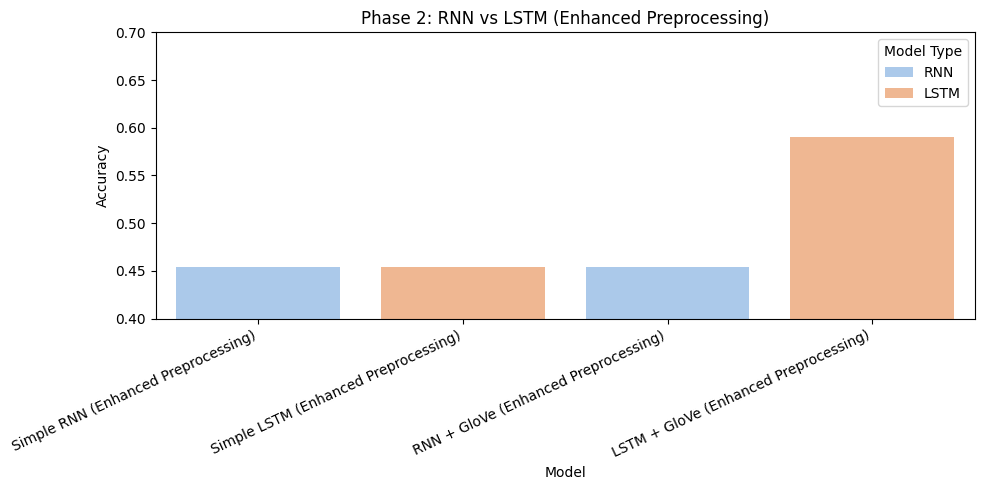

In [214]:
# Define Phase 2 model names
phase2_models = [
    'Simple RNN (Enhanced Preprocessing)',
    'Simple LSTM (Enhanced Preprocessing)',
    'RNN + GloVe (Enhanced Preprocessing)',
    'LSTM + GloVe (Enhanced Preprocessing)'
]

# Filter and annotate
df_phase2 = pd.DataFrame([r for r in results if r['Model'] in phase2_models])
df_phase2['Type'] = df_phase2['Model'].apply(lambda x: 'RNN' if 'RNN' in x else 'LSTM')

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=df_phase2, x='Model', y='Accuracy', hue='Type', palette='pastel')
plt.title('Phase 2: RNN vs LSTM (Enhanced Preprocessing)')
plt.ylim(0.4, 0.7)
plt.ylabel('Accuracy')
plt.xticks(rotation=25, ha='right')
plt.legend(title='Model Type')
plt.tight_layout()


plt.savefig("phase2.png", dpi=300, bbox_inches='tight')

plt.show()


## Compare Bi-RNN vs Bi-LSTM (with Enhanced Preprocessing) and GloVe Models

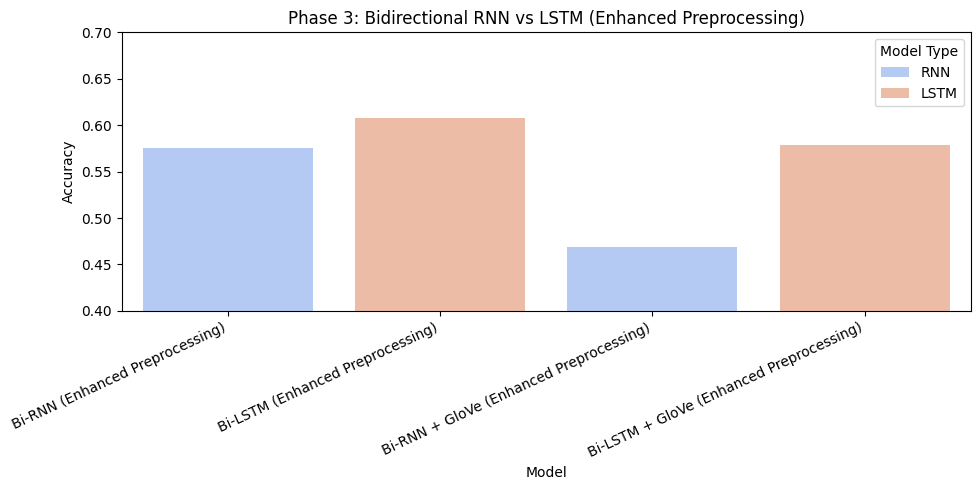

In [215]:
# Define Phase 3 model names
phase3_models = [
    'Bi-RNN (Enhanced Preprocessing)',
    'Bi-LSTM (Enhanced Preprocessing)',
    'Bi-RNN + GloVe (Enhanced Preprocessing)',
    'Bi-LSTM + GloVe (Enhanced Preprocessing)'
]

# Filter and annotate
df_phase3 = pd.DataFrame([r for r in results if r['Model'] in phase3_models])
df_phase3['Type'] = df_phase3['Model'].apply(lambda x: 'RNN' if 'RNN' in x else 'LSTM')

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=df_phase3, x='Model', y='Accuracy', hue='Type', palette='coolwarm')
plt.title('Phase 3: Bidirectional RNN vs LSTM (Enhanced Preprocessing)')
plt.ylim(0.4, 0.7)
plt.ylabel('Accuracy')
plt.xticks(rotation=25, ha='right')
plt.legend(title='Model Type')
plt.tight_layout()


plt.savefig("phase3.png", dpi=300, bbox_inches='tight')


plt.show()




## Take a look at all Histories

In [216]:
for model_name, history in histories.items():
    print(f"\n📘 {model_name}")
    print("Keys:", list(history.history.keys()))
    print("Epochs logged:", len(history.history['accuracy']))
    print("Final Accuracy:", history.history['accuracy'][-1])
    print("Final Val Accuracy:", history.history['val_accuracy'][-1])



📘 Simple RNN (Baseline)
Keys: ['accuracy', 'loss', 'val_accuracy', 'val_loss']
Epochs logged: 5
Final Accuracy: 0.4536040127277374
Final Val Accuracy: 0.4520052671432495

📘 Simple LSTM (Baseline)
Keys: ['accuracy', 'loss', 'val_accuracy', 'val_loss']
Epochs logged: 5
Final Accuracy: 0.4549190402030945
Final Val Accuracy: 0.4520052671432495

📘 Simple RNN + GloVe
Keys: ['accuracy', 'loss', 'val_accuracy', 'val_loss']
Epochs logged: 5
Final Accuracy: 0.4549190402030945
Final Val Accuracy: 0.4520052671432495

📘 Simple LSTM + GloVe
Keys: ['accuracy', 'loss', 'val_accuracy', 'val_loss']
Epochs logged: 5
Final Accuracy: 0.6167502403259277
Final Val Accuracy: 0.612754762172699

📘 Simple RNN + Enhanced Preprocessing
Keys: ['accuracy', 'loss', 'val_accuracy', 'val_loss']
Epochs logged: 5
Final Accuracy: 0.4549190402030945
Final Val Accuracy: 0.4520052671432495

📘 Simple LSTM + Enhanced Preprocessing
Keys: ['accuracy', 'loss', 'val_accuracy', 'val_loss']
Epochs logged: 5
Final Accuracy: 0.454919

## Models to compare:
1. Simple RNN (Baseline)

2. Simple LSTM (Baseline)

3. Simple RNN + GloVe

4. Simple LSTM + GloVe

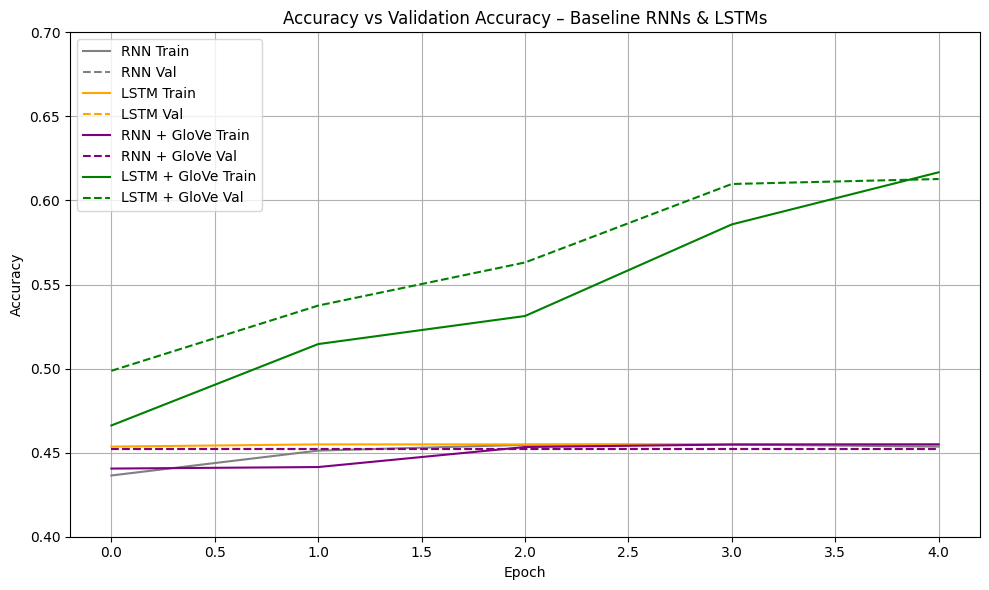

In [217]:
plt.figure(figsize=(10, 6))

# Simple RNN (Baseline)
plt.plot(histories['Simple RNN (Baseline)'].history['accuracy'], 'gray', label='RNN Train')
plt.plot(histories['Simple RNN (Baseline)'].history['val_accuracy'], 'gray', linestyle='--', label='RNN Val')

# Simple LSTM (Baseline)
plt.plot(histories['Simple LSTM (Baseline)'].history['accuracy'], 'orange', label='LSTM Train')
plt.plot(histories['Simple LSTM (Baseline)'].history['val_accuracy'], 'orange', linestyle='--', label='LSTM Val')

# Simple RNN + GloVe
plt.plot(histories['Simple RNN + GloVe'].history['accuracy'], 'purple', label='RNN + GloVe Train')
plt.plot(histories['Simple RNN + GloVe'].history['val_accuracy'], 'purple', linestyle='--', label='RNN + GloVe Val')

# Simple LSTM + GloVe
plt.plot(histories['Simple LSTM + GloVe'].history['accuracy'], 'green', label='LSTM + GloVe Train')
plt.plot(histories['Simple LSTM + GloVe'].history['val_accuracy'], 'green', linestyle='--', label='LSTM + GloVe Val')

plt.title("Accuracy vs Validation Accuracy – Baseline RNNs & LSTMs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0.4, 0.7)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("baseline_models_val.png", dpi=300, bbox_inches='tight')


plt.show()




##  Models to Compare:
1. Simple RNN + Enhanced Preprocessing

2. Simple LSTM + Enhanced Preprocessing

3. RNN + Enhanced Preprocessing and GloVe

4. LSTM + Enhanced Preprocessing and GloVe

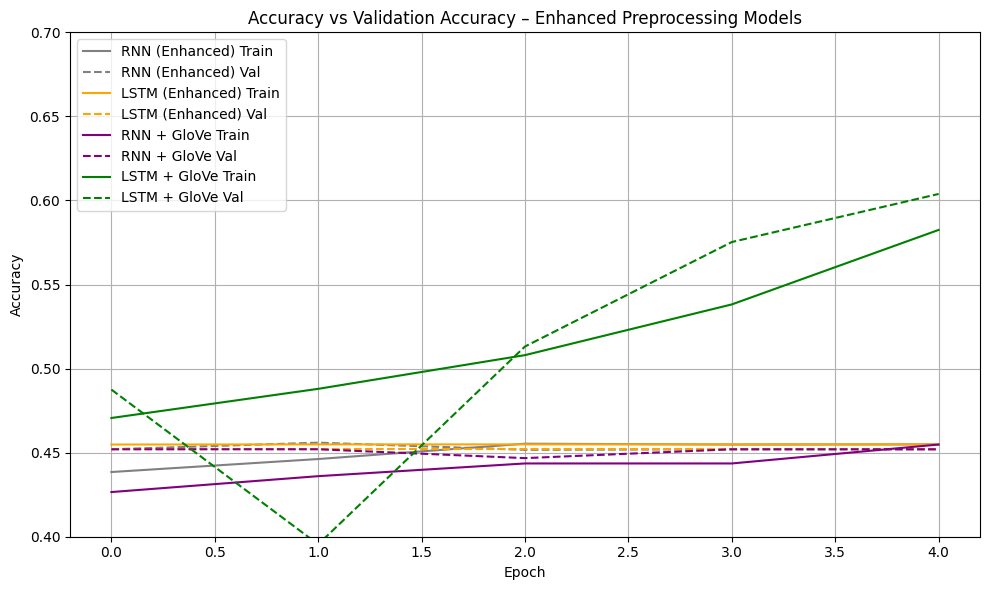

In [218]:
plt.figure(figsize=(10, 6))

# Simple RNN + Enhanced Preprocessing
plt.plot(histories['Simple RNN + Enhanced Preprocessing'].history['accuracy'], 'gray', label='RNN (Enhanced) Train')
plt.plot(histories['Simple RNN + Enhanced Preprocessing'].history['val_accuracy'], 'gray', linestyle='--', label='RNN (Enhanced) Val')

# Simple LSTM + Enhanced Preprocessing
plt.plot(histories['Simple LSTM + Enhanced Preprocessing'].history['accuracy'], 'orange', label='LSTM (Enhanced) Train')
plt.plot(histories['Simple LSTM + Enhanced Preprocessing'].history['val_accuracy'], 'orange', linestyle='--', label='LSTM (Enhanced) Val')

# RNN + Enhanced Preprocessing and GloVe
plt.plot(histories['RNN + Enhanced Preprocessing and GloVe'].history['accuracy'], 'purple', label='RNN + GloVe Train')
plt.plot(histories['RNN + Enhanced Preprocessing and GloVe'].history['val_accuracy'], 'purple', linestyle='--', label='RNN + GloVe Val')

# LSTM + Enhanced Preprocessing and GloVe
plt.plot(histories['LSTM + Enhanced Preprocessing and GloVe'].history['accuracy'], 'green', label='LSTM + GloVe Train')
plt.plot(histories['LSTM + Enhanced Preprocessing and GloVe'].history['val_accuracy'], 'green', linestyle='--', label='LSTM + GloVe Val')

plt.title("Accuracy vs Validation Accuracy – Enhanced Preprocessing Models")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0.4, 0.7)
plt.legend()
plt.grid(True)
plt.tight_layout()


plt.savefig("enhanced_pre_models_val.png", dpi=300, bbox_inches='tight')


plt.show()




## Models to Compare:
1. Bi-RNN + Enhanced Preprocessing

2. Bi-LSTM + Enhanced Preprocessing

3. Bi-RNN + Enhanced Preprocessing and GloVe

4. Bi-LSTM + Enhanced Preprocessing and GloVe

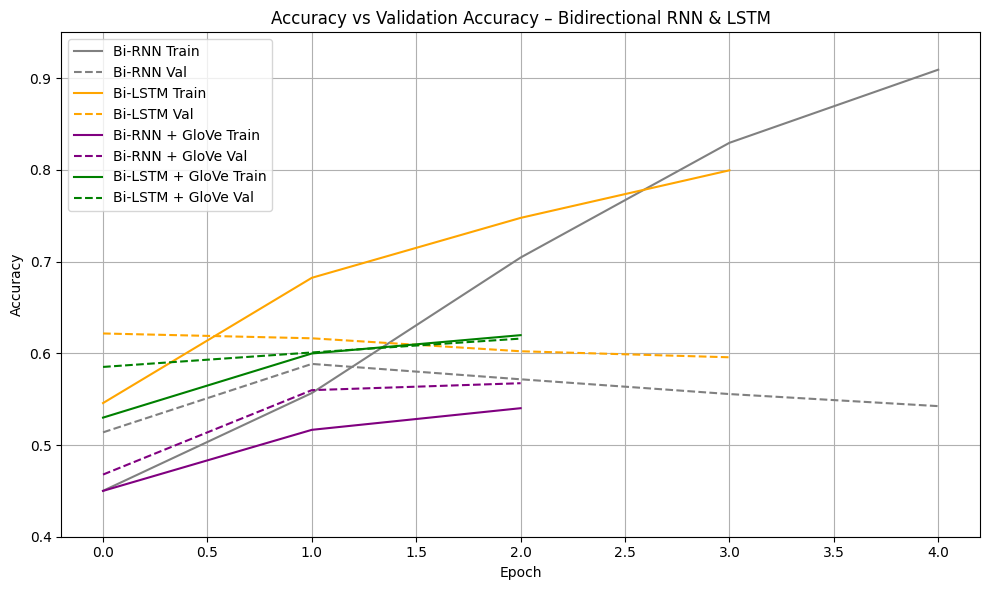

In [219]:
plt.figure(figsize=(10, 6))

# Bi-RNN
plt.plot(histories['Bi-RNN + Enhanced Preprocessing'].history['accuracy'], 'gray', label='Bi-RNN Train')
plt.plot(histories['Bi-RNN + Enhanced Preprocessing'].history['val_accuracy'], 'gray', linestyle='--', label='Bi-RNN Val')

# Bi-LSTM
plt.plot(histories['Bi-LSTM + Enhanced Preprocessing'].history['accuracy'], 'orange', label='Bi-LSTM Train')
plt.plot(histories['Bi-LSTM + Enhanced Preprocessing'].history['val_accuracy'], 'orange', linestyle='--', label='Bi-LSTM Val')

# Bi-RNN + GloVe
plt.plot(histories['Bi-RNN + Enhanced Preprocessing and GloVe'].history['accuracy'], 'purple', label='Bi-RNN + GloVe Train')
plt.plot(histories['Bi-RNN + Enhanced Preprocessing and GloVe'].history['val_accuracy'], 'purple', linestyle='--', label='Bi-RNN + GloVe Val')

# Bi-LSTM + GloVe
plt.plot(histories['Bi-LSTM + Enhanced Preprocessing and GloVe'].history['accuracy'], 'green', label='Bi-LSTM + GloVe Train')
plt.plot(histories['Bi-LSTM + Enhanced Preprocessing and GloVe'].history['val_accuracy'], 'green', linestyle='--', label='Bi-LSTM + GloVe Val')

plt.title("Accuracy vs Validation Accuracy – Bidirectional RNN & LSTM")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0.4, 0.95)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("bi_models_val.png", dpi=300, bbox_inches='tight')


plt.show()




## Final LSTM Faceoff
### 🔹 Models to Compare:
Simple LSTM + GloVe (Enhanced Preprocessing) - Final

Bi-LSTM + GloVe (Enhanced Preprocessing) - Final

Simple LSTM + GloVe (Simple Preprocessing) - Final

C:\Users\7ahme\AppData\Local\Temp\ipykernel_31644\980815067.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_final_lstm, x='Model', y='Accuracy', palette='viridis')


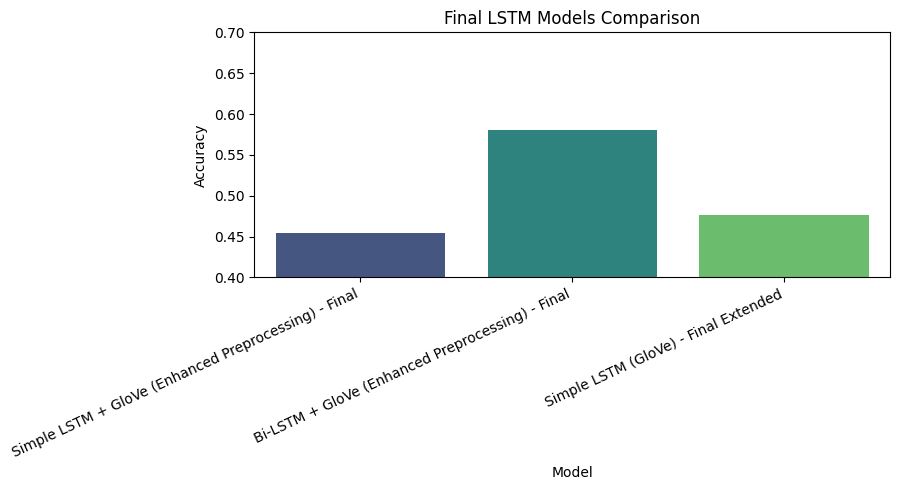

In [220]:
# Final LSTM showdown
final_lstms = [
    'Simple LSTM (GloVe) - Final Extended',
    'Simple LSTM + GloVe (Enhanced Preprocessing) - Final',
    'Bi-LSTM + GloVe (Enhanced Preprocessing) - Final'
]


# Filter results
df_final_lstm = pd.DataFrame([r for r in results if r['Model'] in final_lstms])

# Plot
plt.figure(figsize=(9, 5))
sns.barplot(data=df_final_lstm, x='Model', y='Accuracy', palette='viridis')
plt.title('Final LSTM Models Comparison')
plt.ylim(0.4, 0.7)
plt.ylabel('Accuracy')
plt.xticks(rotation=25, ha='right')
plt.tight_layout()


plt.savefig("lstm_final.png", dpi=300, bbox_inches='tight')

plt.show()



# Accuracy vs Validation Accuracy

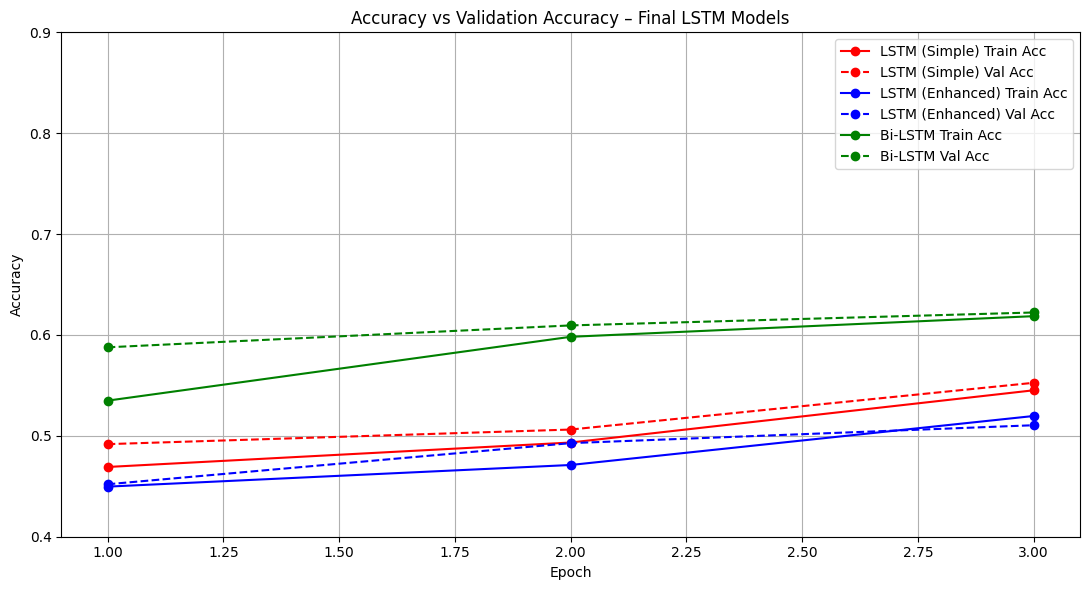

In [221]:
# Extract epoch ranges
epochs_lstm_enhanced = range(1, len(history_lstm_final.history['accuracy']) + 1)
epochs_bilstm_enhanced = range(1, len(history_bilstm_final.history['accuracy']) + 1)
epochs_lstm_extended = range(1, len(history_lstm_glove_final.history['accuracy']) + 1)

# Plot
plt.figure(figsize=(11, 6))

# Simple LSTM (Extended)
plt.plot(epochs_lstm_extended, history_lstm_glove_final.history['accuracy'], 'r-o', label='LSTM (Simple) Train Acc')
plt.plot(epochs_lstm_extended, history_lstm_glove_final.history['val_accuracy'], 'r--o', label='LSTM (Simple) Val Acc')

# Simple LSTM (Enhanced)
plt.plot(epochs_lstm_enhanced, history_lstm_final.history['accuracy'], 'b-o', label='LSTM (Enhanced) Train Acc')
plt.plot(epochs_lstm_enhanced, history_lstm_final.history['val_accuracy'], 'b--o', label='LSTM (Enhanced) Val Acc')

# Bi-LSTM (Enhanced)
plt.plot(epochs_bilstm_enhanced, history_bilstm_final.history['accuracy'], 'g-o', label='Bi-LSTM Train Acc')
plt.plot(epochs_bilstm_enhanced, history_bilstm_final.history['val_accuracy'], 'g--o', label='Bi-LSTM Val Acc')

plt.title('Accuracy vs Validation Accuracy – Final LSTM Models')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.4, 0.9)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("lstm_final_val.png", dpi=300, bbox_inches='tight')


plt.show()

